In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Read in model data - round level (37,676)
model_data = pd.read_csv('C:\\KF_Repo\\PGA_Golf\\Tournament_level_model\\Data_manipulation\\model_data.csv')


# Group by count using pandas groupby()
grouped_data = model_data.groupby(['tournament id', 'Round'])['Round_total'].mean().reset_index()

# Rename columns
grouped_data = grouped_data.rename(columns={"tournament id": "tournament id", 
                                            "Round": "Round",
                                            "Round_total": "Avg_Score"})

# Round Avg Score to 2 decimal places (same as strokes gained)
grouped_data['Avg_Score'] = grouped_data['Avg_Score'].round(2)

# Merge dataframes by 'tournament.id' and 'Round'
add_avg = pd.merge(model_data, grouped_data, on=['tournament id', 'Round'])


# Add difference - put same format as strokes gained
# Negative is bad, positive is good
add_avg['Round_sg'] = add_avg['Avg_Score'] - add_avg['Round_total']

# Filter data for players that you want to analyze
my_players = ['Seamus Power', 'Tony Finau']
mydata2 = add_avg[add_avg['player'].isin(my_players)]

# Convert date to datetime format
mydata2['date'] = pd.to_datetime(mydata2['date'])

# Add in a column for date of round
mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')

# Find the earliest date
earliest_date = mydata2['date_round'].min()

# Calculate the time column
mydata2['time'] = (mydata2['date_round'] - earliest_date).dt.days

# Create a sequence of unique dates and assign corresponding time values
unique_dates = mydata2['date_round'].unique()
date_to_time_mapping = pd.DataFrame({'date_round': unique_dates, 'time_2': np.arange(len(unique_dates))})

# Merge the mapping with the original dataframe
mydata2 = pd.merge(mydata2, date_to_time_mapping, on='date_round', how='left')

# Concatenate columns with "_"
unique_tr = mydata2[['tournament name','date_round', 'Round']].drop_duplicates()
unique_tr['cr'] = unique_tr['tournament name'].astype(str) + "_"+ unique_tr['date_round'].astype(str) + "_" +"R"+ unique_tr['Round'].astype(str)

# Concatenate columns with "_"
unique_tourn = mydata2[['tournament name', 'date']].drop_duplicates()
unique_tourn['tourn'] = unique_tourn['tournament name'].astype(str) + "_" + unique_tourn['date'].astype(str)

# Create additional dataframe before filter
mydata_all = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata_all = pd.merge(mydata_all, unique_tourn, on=['tournament name', 'date'], how='left')

# Keep using mydata2
mydata2 = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata2 = pd.merge(mydata2, unique_tourn, on=['tournament name', 'date'], how='left')


# Filter train and test data
train_data = mydata_all[mydata_all['date_round'] <= "2020-08-30"]
test_data = mydata_all[mydata_all['date_round'] > "2020-08-30"]

# Perform Regression on training data
reg_data = train_data

# Filter by player
power = reg_data[reg_data['player'] == "Seamus Power"]

# Order by date round
power = power.sort_values(by='date_round')

# Create a time series object
ts_data = pd.Series(power['Round_sg'].values, index=power['date_round'])

## partition into train and test
train_series = ts_data[:80]
test_series = ts_data[80:103]


C:\Users\killi\AppData\Local\Temp/ipykernel_1348/2134199291.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date'] = pd.to_datetime(mydata2['date'])
C:\Users\killi\AppData\Local\Temp/ipykernel_1348/2134199291.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')
C:\Users\killi\AppData\Local\Temp/ipykernel_1348/2134199291.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                   80
Model:             ExponentialSmoothing   SSE                            855.863
Optimized:                         True   AIC                            193.607
Trend:                             None   BIC                            198.371
Seasonal:                          None   AICC                           194.140
Seasonal Periods:                  None   Date:                 Sat, 29 Jun 2024
Box-Cox:                          False   Time:                         10:18:17
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1135486                alpha                 True
initial_level             -0.63000

C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


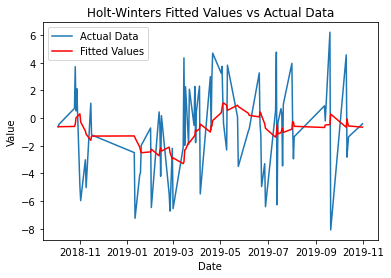

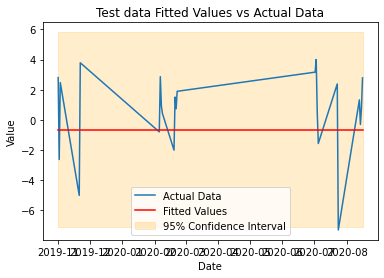

percent obs 95%: 0.96
percent obs 68%: 0.65
percent obs 50%: 0.52


In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt

# Fit Holt-Winters model
# alpha was 0.066
# Trend of model was similar to R, along with Residual Standard Error
HW1 = ExponentialSmoothing(train_series, trend=None, damped_trend=False, seasonal=None, initialization_method = None).fit()

# Print Summary
print(HW1.summary())

# fitted values
fitted_values = HW1.fittedvalues

# Resiudals
residuals = HW1.resid

# Forecast values
forecast_values = HW1.forecast(steps=len(test_series))

# Plot actual data
plt.plot(train_series.index, train_series.values, label='Actual Data')

# Plot fitted values
plt.plot(HW1.fittedvalues.index, HW1.fittedvalues.values, color='red', label='Fitted Values')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Holt-Winters Fitted Values vs Actual Data')
plt.legend()

# Show plot
plt.show()

# Plot test values

# Plot actual data
plt.plot(test_series.index, test_series.values, label='Actual Data')

# Plot fitted values
plt.plot(test_series.index, forecast_values.values, color='red', label='Fitted Values')

# Extract upper and lower confidence intervals
# This number is slightly different than Residuals squared but it works
lower_ci = forecast_values.values - 1.96 * HW1.resid.std()  # Assuming 95% confidence interval
upper_ci = forecast_values.values + 1.96 * HW1.resid.std()

# Plot confidence intervals
plt.fill_between(test_series.index, lower_ci, upper_ci, color='orange', alpha=0.2, label='95% Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Test data Fitted Values vs Actual Data')
plt.legend()

# Show plot
plt.show()

# Count observations that fall within range
# Calculate lower and upper confidence intervals
# Changed to 1.99 for t distribution
lower_ci_95 = forecast_values.values - 1.99 * HW1.resid.std()  # Assuming 95% confidence interval
upper_ci_95 = forecast_values.values + 1.99 * HW1.resid.std()

lower_ci_68 = forecast_values.values - HW1.resid.std()  # Assuming 68% CI
upper_ci_68 = forecast_values.values + HW1.resid.std()

lower_ci_50 = forecast_values.values - 0.675 * HW1.resid.std()  # Assuming 50% CI
upper_ci_50 = forecast_values.values + 0.675 * HW1.resid.std()


# Count observations within confidence intervals
observations_within_ci_95 = ((test_series.values >= lower_ci_95) & (test_series.values <= upper_ci_95)).sum()
# Count observations within confidence intervals
observations_within_ci_68 = ((test_series.values >= lower_ci_68) & (test_series.values <= upper_ci_68)).sum()
# Count observations within confidence intervals
observations_within_ci_50 = ((test_series.values >= lower_ci_50) & (test_series.values <= upper_ci_50)).sum()



# Print the percentages
# How close to percentages should I be
# I am only testing how many observations fall within prediction intervals
print("percent obs 95%:", round(observations_within_ci_95/len(test_series),2))
print("percent obs 68%:", round(observations_within_ci_68/len(test_series),2))
print("percent obs 50%:", round(observations_within_ci_50/len(test_series),2))


